# Transfer learning - Scaling-up

A common practice in ML is to train a model in a small amount of data before scaling it up to larger amounts

<img src='https://camo.githubusercontent.com/3a44366f7797035e9e0dae2900708e0c146718f373136a0ba3a8251a4e63f6ec/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6d7264626f75726b652f74656e736f72666c6f772d646565702d6c6561726e696e672f6d61696e2f696d616765732f30362d6d6c2d73657269616c2d6578706572696d656e746174696f6e2e706e67'>

Past few notebooks focused on 10 classes, here all 101 classes will be explored

In [1]:
!nvidia-smi

Sun Oct  2 03:49:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Import helper functions
!wget https://raw.githubusercontent.com/Ammar-Raneez/TF_Learning_ZTM/main/helper_functions.py

--2022-10-02 03:51:27--  https://raw.githubusercontent.com/Ammar-Raneez/TF_Learning_ZTM/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9822 (9.6K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.59K  --.-KB/s    in 0s      

2022-10-02 03:51:27 (90.7 MB/s) - ‘helper_functions.py’ saved [9822/9822]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## Phase 01 - 10% of data

### Data Exploration

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

unzip_data('101_food_classes_10_percent.zip')

train_dir = '101_food_classes_10_percent/train/'
test_dir = '101_food_classes_10_percent/test/'

--2022-10-02 04:10:33--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.203.128, 74.125.20.128, 108.177.98.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   191MB/s    in 6.9s    

2022-10-02 04:10:40 (224 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [9]:
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/crab_cakes'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pad_thai'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/huevos_rancheros'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/club_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/samosa'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/fried_calamari'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/red_velvet_cake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/grilled_cheese_sandwich'.
There are 0 directories and 7

In [12]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

In [8]:
# Create data loaders
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    image_size=IMG_SIZE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=IMG_SIZE,
    # Reproducible test data - so that repeated evaluation & visualizations can be done
    shuffle=False
)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


### Create model

Start with feature extraction transfer-learning and then scale up to fine-tuning.

In [11]:
# Create model checkpoint callback
checkpoint_path = '101_classes_10_percent_data_model_checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True
)

Create data augmentation layer since `image_dataset_from_directory` cannot augment. Additionally, augmentating occurs only during model creation and utilizes the GPU

In [13]:
data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    # preprocessing.Rescaling(1./255) # Not required for EfficientNet
], name='data_augmentation')

<img src='https://camo.githubusercontent.com/823a5d4af3671b64d4854463c09262fd02f801ad34be28dc4890c42ef74b6288/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6d7264626f75726b652f74656e736f72666c6f772d646565702d6c6561726e696e672f6d61696e2f696d616765732f30362d656666696369656e746e657462302d666561747572652d657874726163746f722d776974682d64656e73652d6c617965722d6f6e2d746f702e706e67'/>

In [16]:
# Create model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=IMG_SIZE + (3,), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)

# Pool outputs of base model to a shape that can be used by the output layer
x = layers.GlobalAveragePooling2D(name='global_avg_pooling')(x)
outputs = layers.Dense(len(train_data_10_percent.class_names), activation='linear', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)

In [17]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pooling (GlobalA  (None, 1280)             0         
 veragePooling2D)                                                
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

In [21]:
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

history_1 = model.fit(
    train_data_10_percent,
    epochs=5,
    validation_data = test_data,
    validation_steps = .25 * len(test_data),
    callbacks=[checkpoint_callback]
)

Epoch 1/5
237/237 [==============================] - 97s 341ms/step - loss: 3.4803 - accuracy: 0.2512 - val_loss: 2.7320 - val_accuracy: 0.3529
Epoch 2/5
237/237 [==============================] - 65s 271ms/step - loss: 2.3528 - accuracy: 0.4634 - val_loss: 2.3214 - val_accuracy: 0.4151
Epoch 3/5
237/237 [==============================] - 55s 231ms/step - loss: 1.9883 - accuracy: 0.5237 - val_loss: 2.1277 - val_accuracy: 0.4545
Epoch 4/5
237/237 [==============================] - 58s 244ms/step - loss: 1.7721 - accuracy: 0.5650 - val_loss: 2.0527 - val_accuracy: 0.4642
Epoch 5/5
237/237 [==============================] - 53s 224ms/step - loss: 1.5996 - accuracy: 0.6104 - val_loss: 2.0013 - val_accuracy: 0.4727


In [25]:
feature_extract_results = model.evaluate(test_data)
feature_extract_results

790/790 [==============================] - 58s 73ms/step - loss: 1.7290 - accuracy: 0.5480


[1.7289990186691284, 0.5479999780654907]

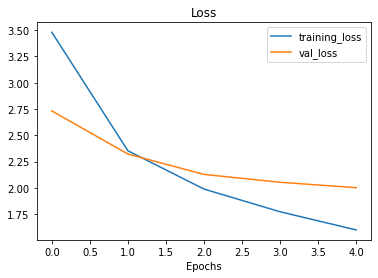

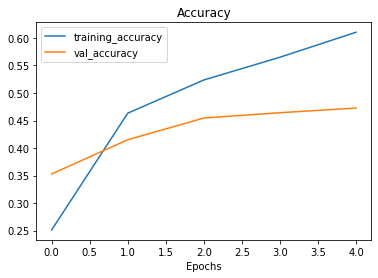

In [26]:
plot_loss_curves(history_1)